<a href="https://colab.research.google.com/github/Jesse-cyber-prog/Final-Year-Project/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

# Data Cleaning

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Handle Missing Values

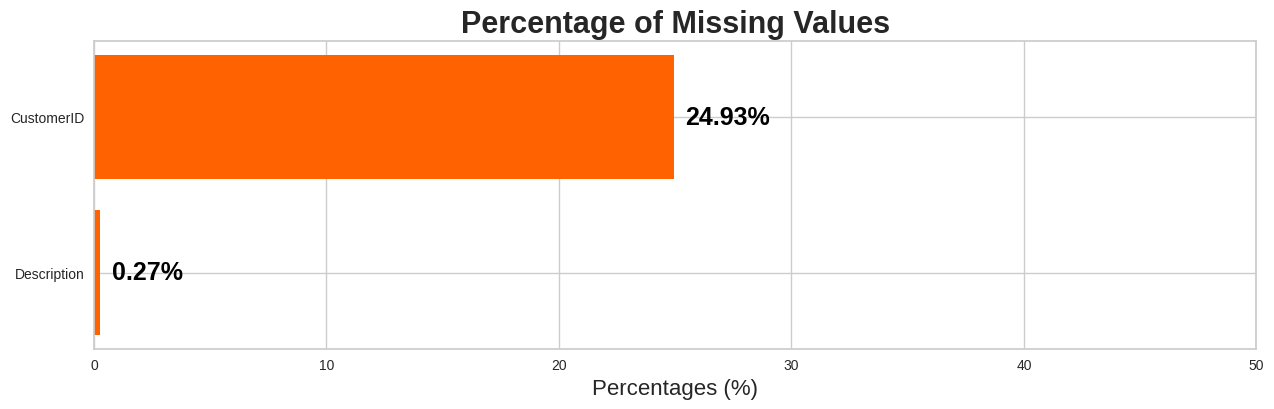

In [7]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim(0, 50)

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [8]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [9]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

Handling Duplicates

In [10]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [11]:
# Getting the number of rows in the dataframe
df.shape[0]

401604

Correcting StockCode Anomalies

In [12]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


In [13]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [14]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [15]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [16]:
# Getting the number of rows in the dataframe
df.shape[0]

399689

Cleaning Description Column

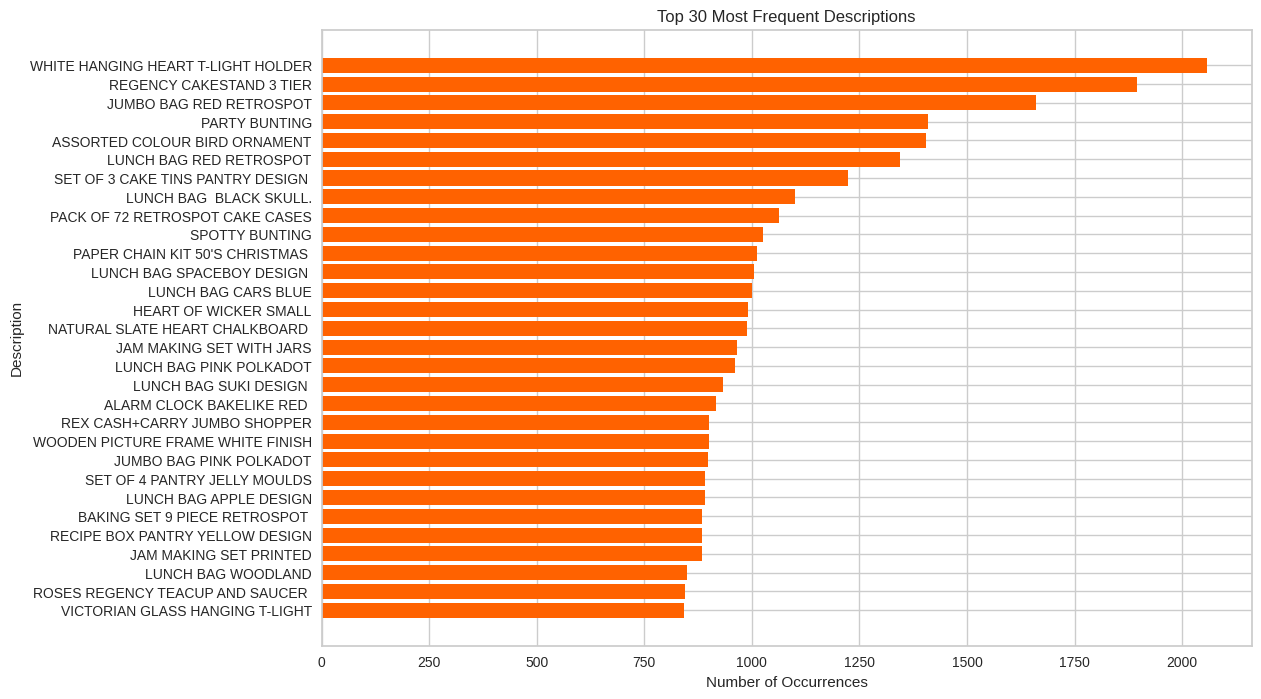

In [17]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [18]:
# Find unique descriptions containing lowercase characters
lowercase = df['Description'].unique()
lowercase = [desc for desc in lowercase if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [19]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [20]:
# Getting the number of rows in the dataframe
df.shape[0]

399606

Removing Free Items

In [21]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [22]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [23]:
# Getting the number of rows in the dataframe
df.shape[0]

399573

# Data Enrichment

Treating Cancelled Transactions

In [24]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8505.000000,8505.000000
mean,-31.476778,4.438907
std,1197.121933,9.198968
min,-80995.000000,0.030000
25%,-6.000000,1.450000
50%,-2.000000,2.550000
75%,-1.000000,4.950000
max,-1.000000,295.000000


In [25]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.13%


Creating new dataframe

In [26]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [27]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

In [28]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

In [29]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

In [30]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

In [31]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Country']], on='CustomerID')

In [32]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

In [33]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Monthly Buying Patterns
monthly_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
monthly_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
monthly_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, monthly_buying_patterns, on='CustomerID')

In [34]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [35]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Hour,Country,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,325,2,0,0.0,0.0,1,0.0,10,United Kingdom,1,0.5,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,14,Iceland,0,0.0,615.714286,341.070789
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,19,Finland,0,0.0,359.31,203.875689
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,9,Italy,0,0.0,1457.55,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,16,Norway,0,0.0,294.4,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,14,Norway,1,0.125,316.3525,134.700629
6,12353.0,204,1,20,89.0,89.0,4,0.0,17,Bahrain,0,0.0,89.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,13,Spain,0,0.0,1079.4,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,13,Bahrain,0,0.0,459.4,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,9,Portugal,0,0.0,829.143333,991.462585


In [36]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Hour                            4282 non-null   Int32  
 9   Country                         4282 non-null   string 
 10  Cancellation_Frequency          4282 non-null   Int64  
 11  Cancellation_Rate               4282 non-null   Float64
 12  Monthly_Spending_Mean           42

# Drop Outliers

In [37]:
from sklearn.preprocessing import LabelEncoder

# Encode Country
label_encoder = LabelEncoder()
customer_data.iloc[:, 9] = label_encoder.fit_transform(customer_data.iloc[:, 9])

# Print the mapping of original values to encoded values
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(mapping)

Label Encoding Mapping:
{'Australia': 0, 'Austria': 1, 'Bahrain': 2, 'Belgium': 3, 'Brazil': 4, 'Canada': 5, 'Channel Islands': 6, 'Cyprus': 7, 'Czech Republic': 8, 'Denmark': 9, 'EIRE': 10, 'European Community': 11, 'Finland': 12, 'France': 13, 'Germany': 14, 'Greece': 15, 'Iceland': 16, 'Israel': 17, 'Italy': 18, 'Japan': 19, 'Lebanon': 20, 'Lithuania': 21, 'Malta': 22, 'Netherlands': 23, 'Norway': 24, 'Poland': 25, 'Portugal': 26, 'RSA': 27, 'Saudi Arabia': 28, 'Singapore': 29, 'Spain': 30, 'Sweden': 31, 'Switzerland': 32, 'USA': 33, 'United Arab Emirates': 34, 'United Kingdom': 35, 'Unspecified': 36}


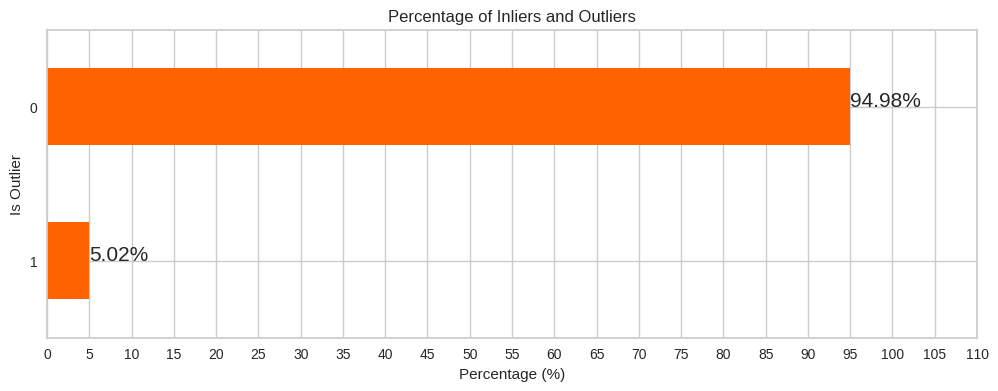

In [38]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [39]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

# Display the cleaned dataset
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Hour,Country,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,325,2,0,0.0,0.0,1,0.0,10,35,1,0.5,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,14,16,0,0.0,615.714286,341.070789
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,19,12,0,0.0,359.31,203.875689
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,9,18,0,0.0,1457.55,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,16,24,0,0.0,294.4,0.0


In [40]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

4067

# Correlation Analysis


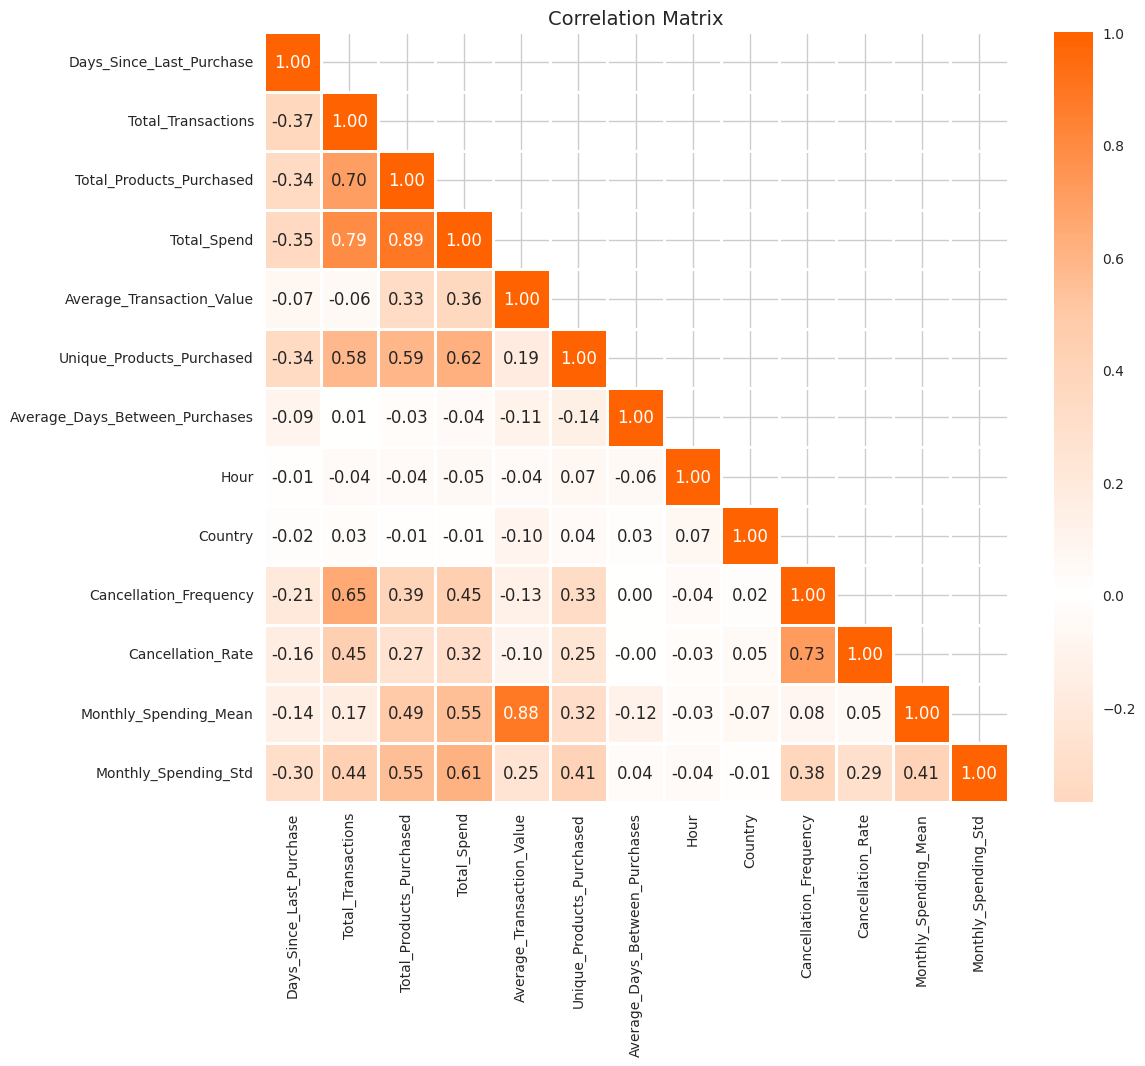

In [41]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

# PCA

In [42]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID','Country']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Hour,Country,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,2.340968,-0.469302,-0.776970,-0.829830,-1.306059,-0.899736,-0.350200,-1.089948,35,0.401446,0.414929,-1.328304,-0.716838
1,12347.0,-0.904418,0.677448,2.073471,2.409531,1.504878,0.785828,-0.129667,0.650630,16,-0.535799,-0.430860,0.979958,1.262745
2,12348.0,-0.170941,-0.010602,1.927354,0.250388,0.334309,-0.569233,0.840145,2.826353,12,-0.535799,-0.430860,0.018720,0.466462
3,12349.0,-0.743656,-0.698652,-0.046385,0.265653,5.348133,0.273548,-0.350200,-1.525092,18,-0.535799,-0.430860,4.135931,-0.716838
4,12350.0,2.190254,-0.698652,-0.549677,-0.608561,0.037973,-0.651859,-0.350200,1.520919,24,-0.535799,-0.430860,-0.224622,-0.716838


In [43]:
# Set the index and apply PCA
customer_data_scaled.set_index('CustomerID', inplace=True)
pca = PCA().fit(customer_data_scaled)

# Calculate explained variance and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a DataFrame to show the results
pca_results = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_explained_variance
})

# Display the table
print(pca_results)

   Principal Component  Explained Variance Ratio  \
0                  PC1                  0.740309   
1                  PC2                  0.100175   
2                  PC3                  0.043924   
3                  PC4                  0.023976   
4                  PC5                  0.022678   
5                  PC6                  0.019115   
6                  PC7                  0.015629   
7                  PC8                  0.011937   
8                  PC9                  0.009608   
9                 PC10                  0.005813   
10                PC11                  0.003601   
11                PC12                  0.001804   
12                PC13                  0.001429   

    Cumulative Explained Variance  
0                        0.740309  
1                        0.840484  
2                        0.884408  
3                        0.908385  
4                        0.931063  
5                        0.950178  
6                  

In [44]:
# Creating a PCA object with 2 components and fitting it again
pca_2d = PCA(n_components=2)
customer_data_pca_2d = pca_2d.fit_transform(customer_data_scaled)

# Create the PCA component DataFrame for 2 components
pc_df = pd.DataFrame(pca_2d.components_.T,
                     columns=['PC1', 'PC2'],
                     index=customer_data_scaled.columns)

# Display the resulting DataFrame
print(pc_df)

                                     PC1       PC2
Days_Since_Last_Purchase        0.003240 -0.218020
Total_Transactions             -0.005767  0.379725
Total_Products_Purchased        0.002095  0.405968
Total_Spend                     0.001976  0.431730
Average_Transaction_Value       0.017691  0.168101
Unique_Products_Purchased      -0.007815  0.333350
Average_Days_Between_Purchases -0.004744 -0.025448
Hour                           -0.012774 -0.021574
Country                        -0.999574  0.000033
Cancellation_Frequency         -0.003362  0.290481
Cancellation_Rate              -0.009044  0.231870
Monthly_Spending_Mean           0.012039  0.266150
Monthly_Spending_Std            0.001008  0.328029


In [45]:
prepared_customer_data = customer_data_cleaned[['Total_Transactions','Total_Products_Purchased','Total_Spend','Unique_Products_Purchased','Country','Monthly_Spending_Std']]

#K-Means Clustering

Elbow Method

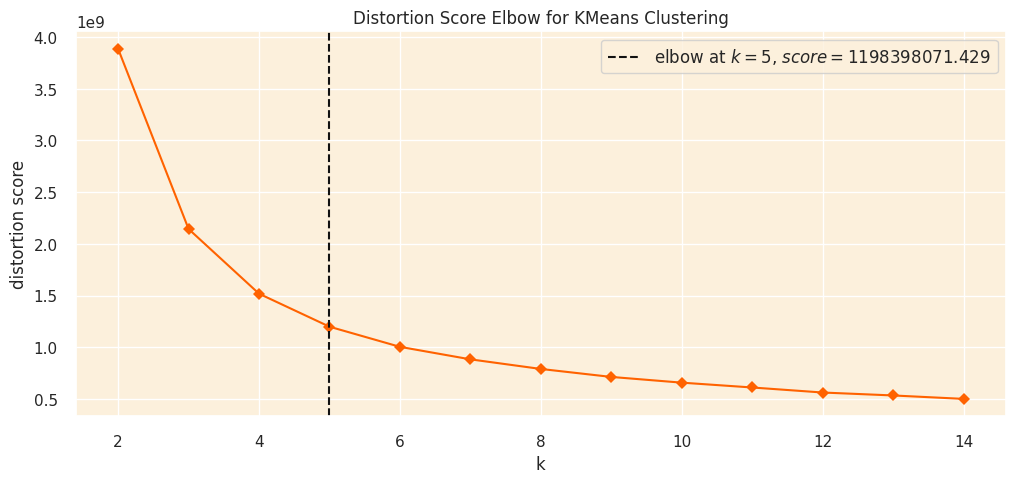

In [46]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(prepared_customer_data)

# Finalize and render the figure
visualizer.show();

In [47]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(prepared_customer_data)

# Use the original KMeans labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the original DataFrame
customer_data_cleaned['cluster'] = cluster_labels


In [48]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Hour,Country,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,10,35,1,0.5,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,14,16,0,0.0,615.714286,341.070789,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,19,12,0,0.0,359.31,203.875689,3
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,9,18,0,0.0,1457.55,0.0,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,16,24,0,0.0,294.4,0.0,1


# Cluster Distribution

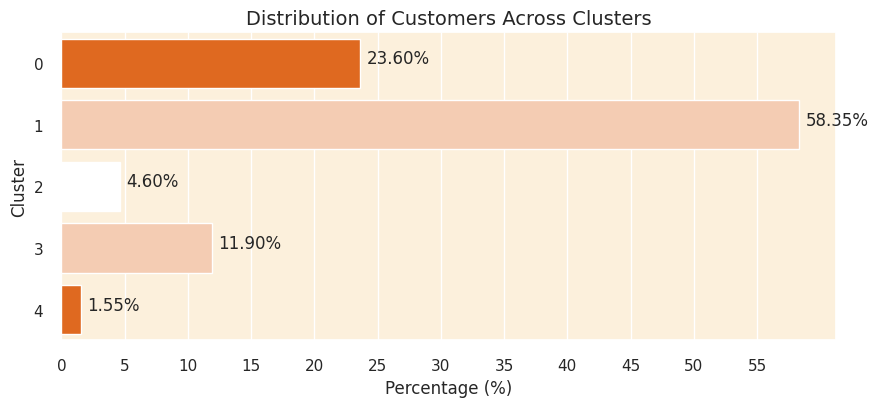

In [49]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_cleaned['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 60, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

# Evaluation Metrics

Silhouette Score: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.

Calinski Harabasz Score: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.

Davies Bouldin Score: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [50]:
# Compute number of customers
num_observations = len(customer_data_cleaned)

# Separate the features and the cluster labels
X = customer_data_cleaned.drop('cluster', axis=1)
clusters = customer_data_cleaned['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4067        |
|    Silhouette Score     | 0.1275915293837579 |
| Calinski Harabasz Score | 703.5471376018028  |
|  Davies Bouldin Score   | 2.225760336668979  |
+-------------------------+--------------------+


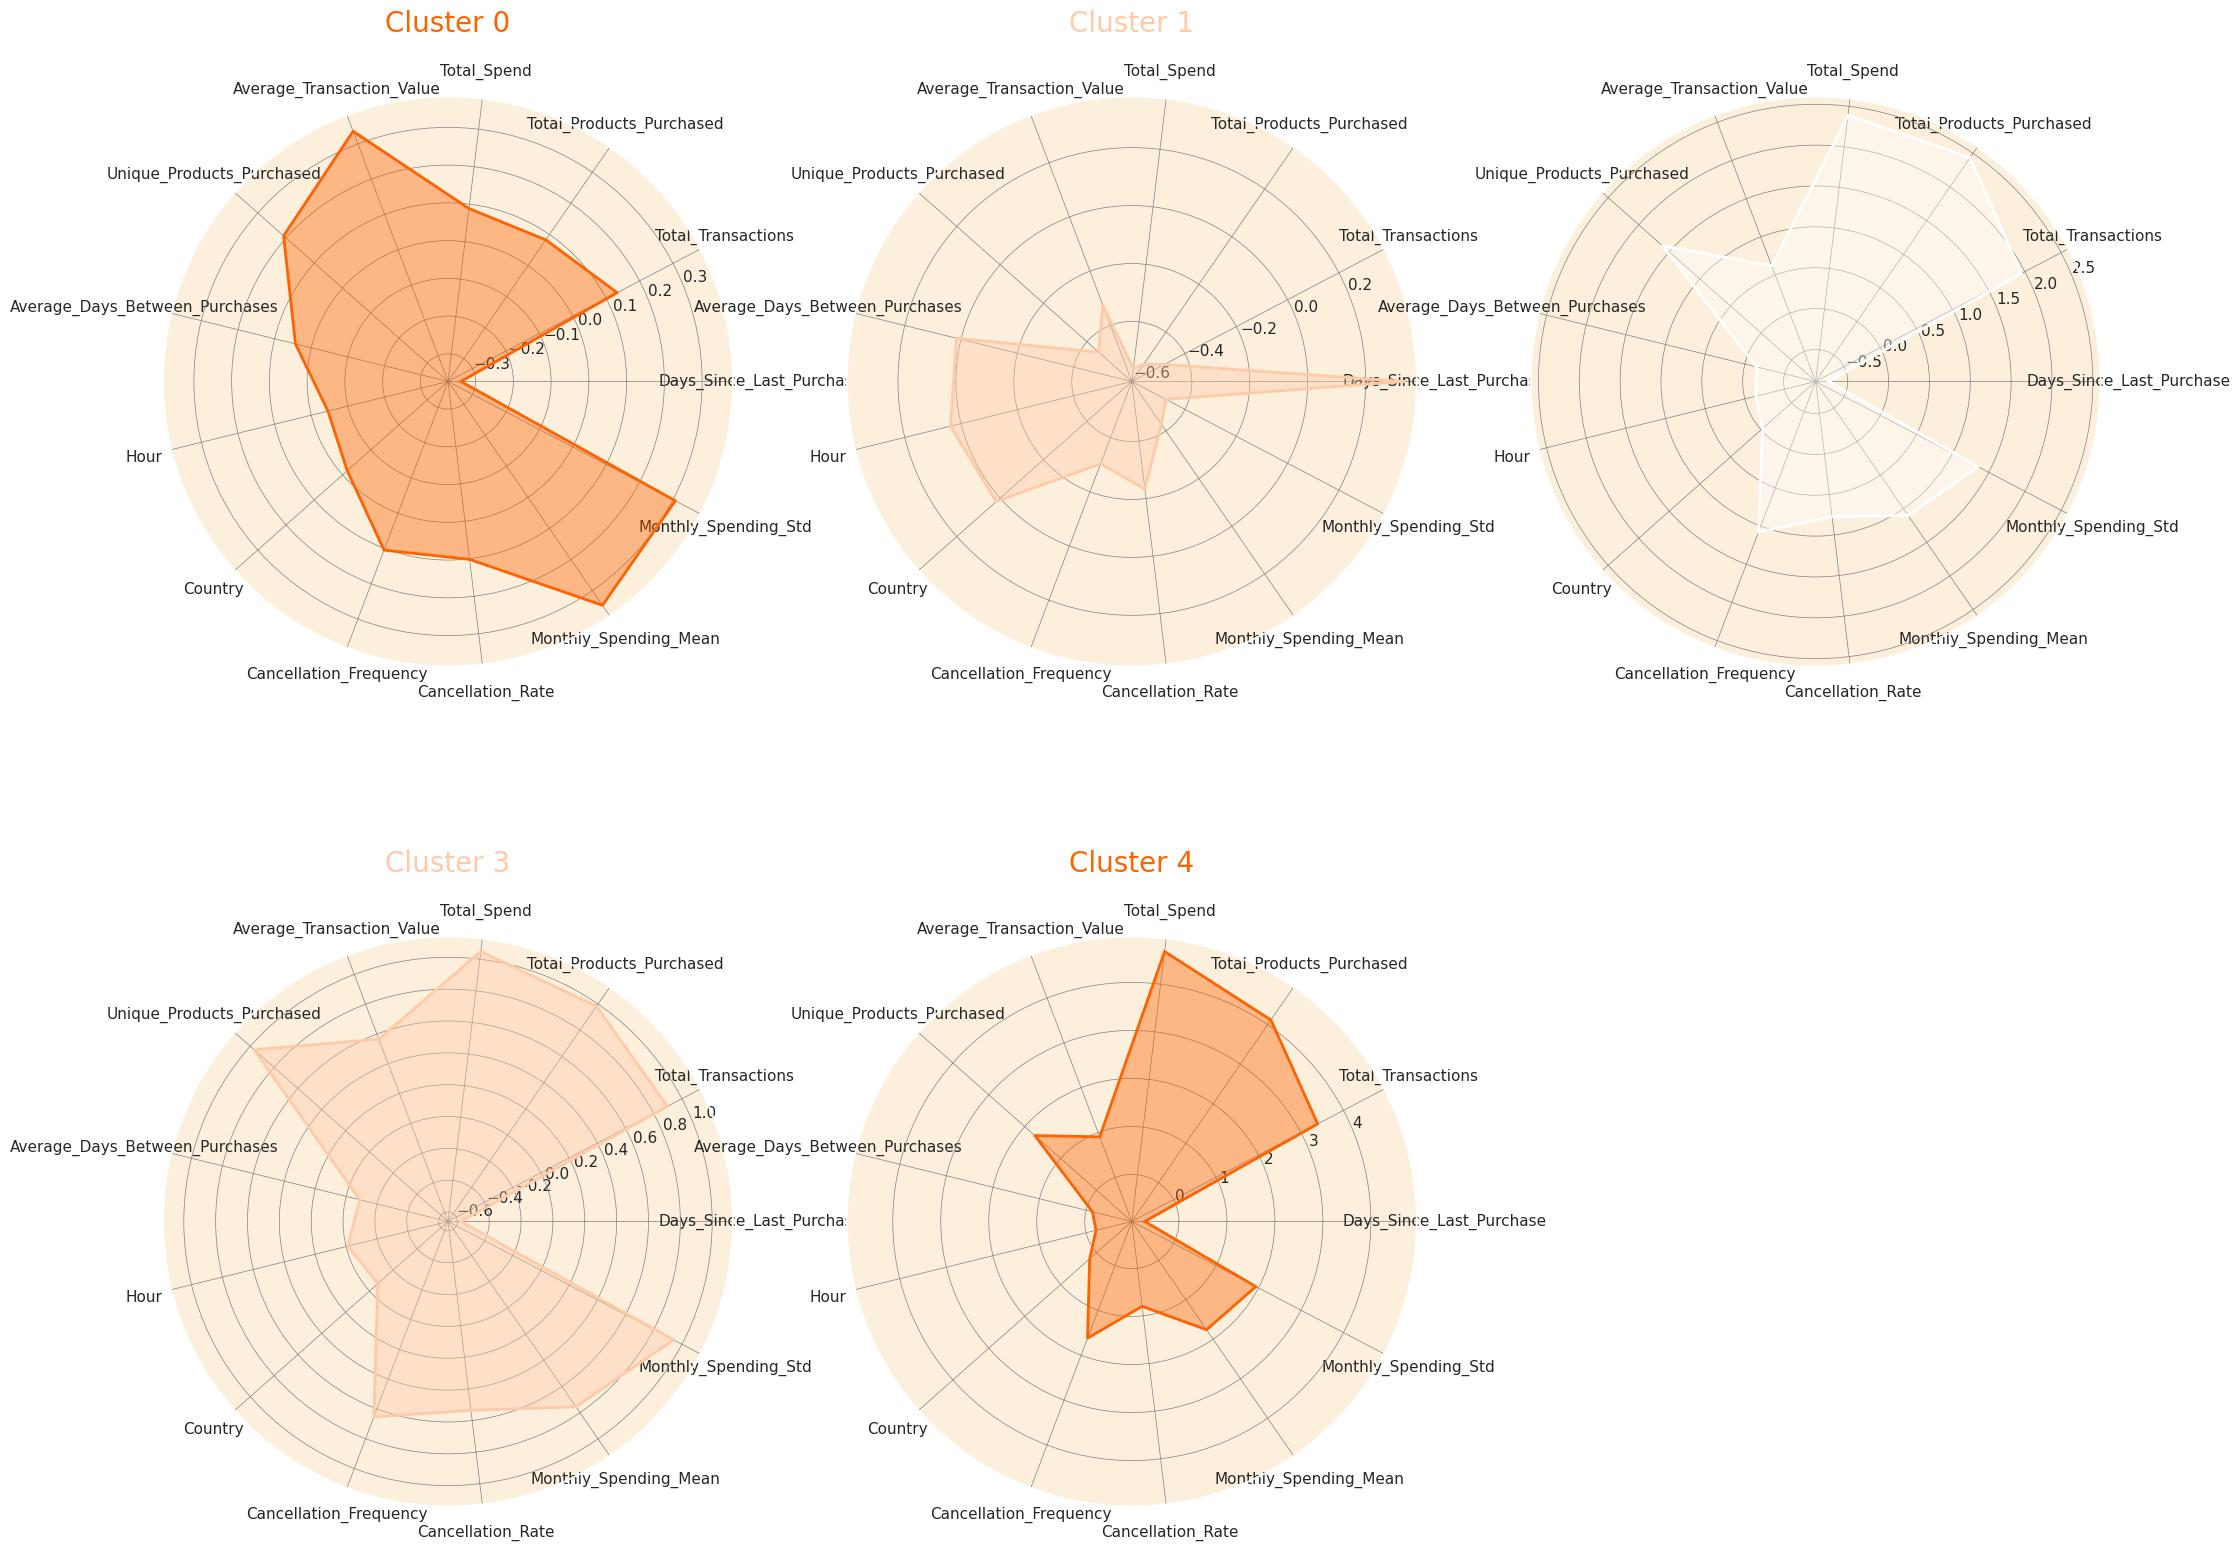

In [53]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Set up a grid spec with more rows for more space
fig = plt.figure(figsize=(25, 20))
gs = GridSpec(2, 3, figure=fig)

# Create subplots within the grid
ax1 = fig.add_subplot(gs[0, 0], polar=True)
ax2 = fig.add_subplot(gs[0, 1], polar=True)
ax3 = fig.add_subplot(gs[0, 2], polar=True)
ax4 = fig.add_subplot(gs[1, 0], polar=True)
ax5 = fig.add_subplot(gs[1, 1], polar=True)

# Store them in a list to iterate over
ax = [ax1, ax2, ax3, ax4, ax5]

# Create radar charts
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Set the labels and grid
for subplot in ax:
    subplot.set_xticks(angles[:-1])
    subplot.set_xticklabels(labels[:-1])
    subplot.grid(color='grey', linewidth=0.5)

plt.show()